In [ ]:
from medmnist import INFO
from medmnist import BloodMNIST, DermaMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from collections import Counter
import torch

dataset_name = 'dermamnist'  # or 'dermamnist'
info = INFO[dataset_name]
dataset_classes = {
    'bloodmnist': BloodMNIST,
    'dermamnist': DermaMNIST
}
DataClass = dataset_classes[dataset_name]

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = DataClass(split='train', size=64, root="data", transform=transform, download=True)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

class_counts = Counter()
for _, labels in dataloader:
    class_counts.update(labels.tolist()[0])

print("Class counts:", class_counts)

n_classes = len(info['label'])
class_counts_dict = dict(class_counts)
weights = [0] * len(train_dataset)
for idx, (_, label) in enumerate(train_dataset):
    class_weight = 1.0 / class_counts_dict[label.item()]
    weights[idx] = class_weight

sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))

val_dataset = DataClass(split='val', size=64, root="data", transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=24, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=24)

n_classes = len(info['label'])
print("Number of classes:", n_classes)

Using downloaded and verified file: data\bloodmnist_64.npz
Class counts: Counter({6: 2330, 1: 2181, 3: 2026, 7: 1643, 2: 1085, 5: 993, 0: 852, 4: 849})
Using downloaded and verified file: data\bloodmnist_64.npz
Number of classes: 8


In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self, num_labels=8, embed_dim=8, latent_dim=20, img_channels=3):
        super().__init__()
        self.latent_dim = latent_dim
        self.embed_dim = embed_dim
        self.num_labels = num_labels

        # Embedding layer for labels
        self.label_embedding = nn.Embedding(num_labels, embed_dim)

        def conv_block(in_channels, out_channels, use_bn=True):
            layers = [nn.Conv2d(in_channels, out_channels, 4, 2, 1)]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        # Encoder: 64x64 -> 32x32 -> 16x16 -> 8x8 -> 4x4
        self.encoder = nn.Sequential(
            conv_block(img_channels + embed_dim, 32),  # 64x64 -> 32x32
            conv_block(32, 64),                       # 32x32 -> 16x16
            conv_block(64, 128),                      # 16x16 -> 8x8
            conv_block(128, 256),                     # 8x8 -> 4x4
            nn.Flatten()
        )
        self.encoder_output_dim = 256 * 4 * 4  # 4x4 feature map with 256 channels

        self.fc_mu = nn.Linear(self.encoder_output_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.encoder_output_dim, latent_dim)

        self.decoder_input = nn.Linear(latent_dim + embed_dim, self.encoder_output_dim)
        # Decoder: 4x4 -> 8x8 -> 16x16 -> 32x32 -> 64x64
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 4, 4)),
            nn.Conv2d(256, 128 * 4, 3, 1, 1),  # 4x4 -> 8x8
            nn.PixelShuffle(2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64 * 4, 3, 1, 1),  # 8x8 -> 16x16
            nn.PixelShuffle(2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32 * 4, 3, 1, 1),   # 16x16 -> 32x32
            nn.PixelShuffle(2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 16 * 4, 3, 1, 1),   # 32x32 -> 64x64
            nn.PixelShuffle(2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, img_channels, 3, 1, 1),
            nn.Sigmoid()
        )

    def encode(self, x, y):
        # y is now a tensor of label indices (e.g., shape [batch_size])
        y_embed = self.label_embedding(y)  # [batch_size] -> [batch_size, embed_dim]
        # Expand embedding to match image dimensions
        y_img = y_embed[:, :, None, None].expand(-1, -1, x.size(2), x.size(3))  # [batch_size, embed_dim, 64, 64]
        x_cat = torch.cat([x, y_img], dim=1)  # Concatenate along channel dimension
        h = self.encoder(x_cat)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        # y is label indices, get embedding
        y_embed = self.label_embedding(y)  # [batch_size, embed_dim]
        z_cat = torch.cat([z, y_embed], dim=1)  # Concatenate embedding with latent vector
        h = self.decoder_input(z_cat)
        return self.decoder(h)

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, y), mu, logvar

In [94]:
import tqdm
import torch
import torch.nn.functional as F

def train(model, train_loader, val_loader, optimizer, device, num_labels, epochs=20, beta_schedule=None):
    model.to(device)
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_recon = 0
        train_kld = 0

        beta = beta_schedule(epoch) if beta_schedule else 1.0

        with tqdm.tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}") as pbar:
            for x, y in pbar:
                x = x.to(device)
                y = y.squeeze().to(device)  # Label indices, shape [batch_size]

                optimizer.zero_grad()
                recon_x, mu, logvar = model(x, y)
                BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
                KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = BCE + beta * KLD

                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_recon += BCE.item()
                train_kld += KLD.item()

                pbar.set_postfix({
                    'Train Loss': f"{train_loss / len(train_loader.dataset):.4f}",
                    'Recon': f"{train_recon / len(train_loader.dataset):.4f}",
                    'KLD': f"{train_kld / len(train_loader.dataset):.4f}",
                    'β': beta
                })

        # Validation phase
        model.eval()
        val_loss = 0
        val_recon = 0
        val_kld = 0

        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.squeeze().to(device)  # Label indices, shape [batch_size]

                recon_x, mu, logvar = model(x, y)
                BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
                KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = BCE + beta * KLD

                val_loss += loss.item()
                val_recon += BCE.item()
                val_kld += KLD.item()

        # Log training and validation metrics
        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss / len(train_loader.dataset):.4f}, "
              f"Train Recon={train_recon / len(train_loader.dataset):.4f}, "
              f"Train KLD={train_kld / len(train_loader.dataset):.4f}, "
              f"Val Loss={val_loss / len(val_loader.dataset):.4f}, "
              f"Val Recon={val_recon / len(val_loader.dataset):.4f}, "
              f"Val KLD={val_kld / len(val_loader.dataset):.4f}, β={beta}")

def beta_schedule(epoch, start=0.0, stop=1.0, warmup_epochs=10):
    if epoch >= warmup_epochs:
        return stop
    return start + (stop - start) * (epoch / warmup_epochs)

# Instantiate the modified CVAE model
model = CVAE(num_labels=n_classes, embed_dim=8, latent_dim=64, img_channels=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train(model, train_loader, val_loader, optimizer, device, num_labels=n_classes, epochs=10, beta_schedule=beta_schedule)

Epoch 1/10: 100%|██████████| 499/499 [00:09<00:00, 51.47it/s, Train Loss=6303.3668, Recon=6303.3668, KLD=1883.1496, β=0]


Epoch 1: Train Loss=6303.3668, Train Recon=6303.3668, Train KLD=1883.1496, Val Loss=6178.5630, Val Recon=6178.5630, Val KLD=1860.1045, β=0.0


Epoch 2/10: 100%|██████████| 499/499 [00:09<00:00, 55.06it/s, Train Loss=6110.7362, Recon=6085.4511, KLD=252.8508, β=0.1]


Epoch 2: Train Loss=6110.7362, Train Recon=6085.4511, Train KLD=252.8508, Val Loss=6096.2482, Val Recon=6078.6152, Val KLD=176.3292, β=0.1


Epoch 3/10: 100%|██████████| 499/499 [00:08<00:00, 55.67it/s, Train Loss=6058.1755, Recon=6029.7165, KLD=142.2950, β=0.2]


Epoch 3: Train Loss=6058.1755, Train Recon=6029.7165, Train KLD=142.2950, Val Loss=6070.7992, Val Recon=6044.4242, Val KLD=131.8751, β=0.2


Epoch 4/10: 100%|██████████| 499/499 [00:09<00:00, 55.26it/s, Train Loss=6037.4985, Recon=6002.1410, KLD=117.8583, β=0.3]


Epoch 4: Train Loss=6037.4985, Train Recon=6002.1410, Train KLD=117.8583, Val Loss=6061.2355, Val Recon=6029.5466, Val KLD=105.6297, β=0.3


Epoch 5/10: 100%|██████████| 499/499 [00:09<00:00, 54.88it/s, Train Loss=6034.6991, Recon=5992.7533, KLD=104.8645, β=0.4]


Epoch 5: Train Loss=6034.6991, Train Recon=5992.7533, Train KLD=104.8645, Val Loss=6063.7159, Val Recon=6022.6443, Val KLD=102.6791, β=0.4


Epoch 6/10: 100%|██████████| 499/499 [00:09<00:00, 54.81it/s, Train Loss=6033.4090, Recon=5985.2853, KLD=96.2474, β=0.5]


Epoch 6: Train Loss=6033.4090, Train Recon=5985.2853, Train KLD=96.2474, Val Loss=6064.7183, Val Recon=6017.9456, Val KLD=93.5455, β=0.5


Epoch 7/10: 100%|██████████| 499/499 [00:10<00:00, 46.92it/s, Train Loss=6041.8299, Recon=5988.0340, KLD=89.6597, β=0.6]


Epoch 7: Train Loss=6041.8299, Train Recon=5988.0340, Train KLD=89.6597, Val Loss=6071.6292, Val Recon=6017.8974, Val KLD=89.5530, β=0.6


Epoch 8/10: 100%|██████████| 499/499 [00:09<00:00, 52.29it/s, Train Loss=6032.2267, Recon=5973.0444, KLD=84.5462, β=0.7]


Epoch 8: Train Loss=6032.2267, Train Recon=5973.0444, Train KLD=84.5462, Val Loss=6067.9247, Val Recon=6007.9924, Val KLD=85.6175, β=0.7


Epoch 9/10: 100%|██████████| 499/499 [00:10<00:00, 45.79it/s, Train Loss=6046.5888, Recon=5982.5566, KLD=80.0404, β=0.8]


Epoch 9: Train Loss=6046.5888, Train Recon=5982.5566, Train KLD=80.0404, Val Loss=6076.3700, Val Recon=6014.3765, Val KLD=77.4918, β=0.8


Epoch 10/10: 100%|██████████| 499/499 [00:11<00:00, 45.10it/s, Train Loss=6047.9081, Recon=5979.7259, KLD=75.7580, β=0.9]


Epoch 10: Train Loss=6047.9081, Train Recon=5979.7259, Train KLD=75.7580, Val Loss=6084.1186, Val Recon=6016.1551, Val KLD=75.5150, β=0.9


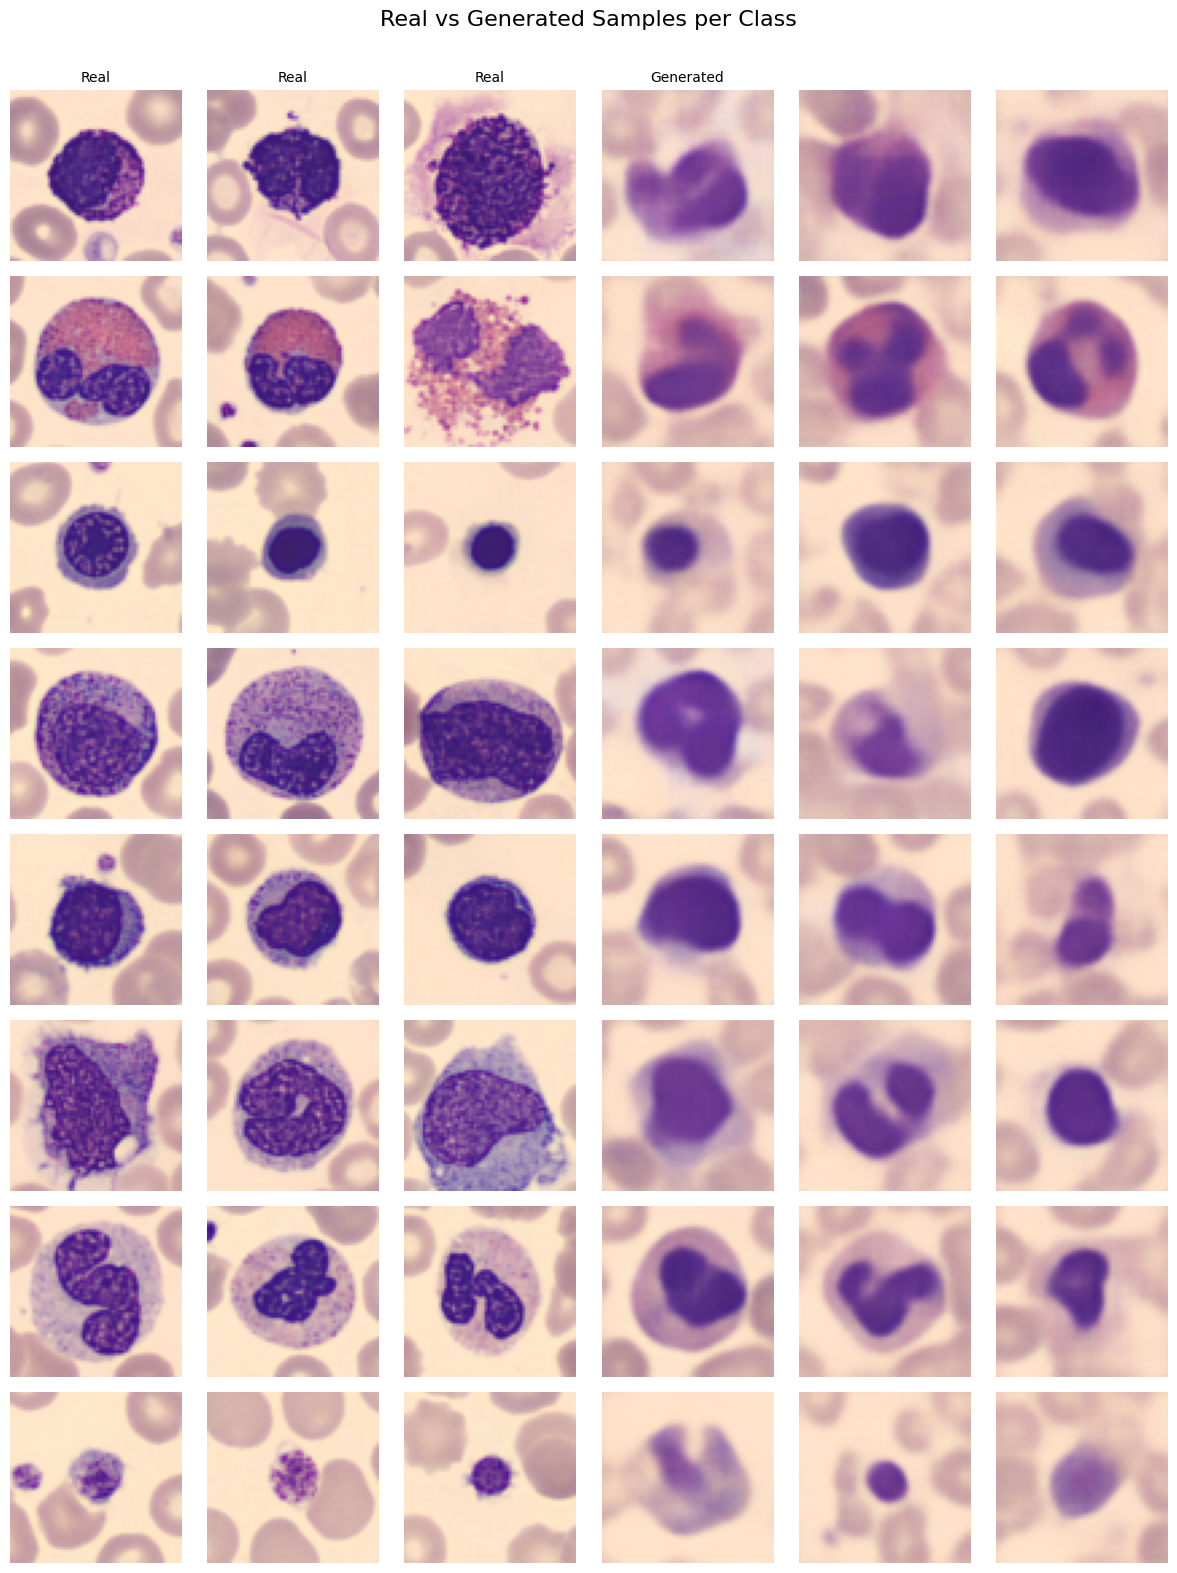

In [95]:
import matplotlib.pyplot as plt
import torch

def visualize_real_vs_generated(model, val_loader, device, n_classes, num_samples_per_class=3):
    model.eval()

    # Collect real images from validation loader
    real_images = {i: [] for i in range(n_classes)}
    with torch.no_grad():
        for x, y in val_loader:
            y = y.squeeze()
            for i in range(len(y)):
                class_idx = y[i].item()
                if len(real_images[class_idx]) < num_samples_per_class:
                    real_images[class_idx].append(x[i])
                if all(len(real_images[c]) >= num_samples_per_class for c in range(n_classes)):
                    break
            if all(len(real_images[c]) >= num_samples_per_class for c in range(n_classes)):
                break

    # Generate fake images
    fake_images = []
    with torch.no_grad():
        for class_idx in range(n_classes):
            y = torch.tensor([class_idx], dtype=torch.long).to(device)
            y = y.repeat(num_samples_per_class)
            z = torch.randn(num_samples_per_class, model.latent_dim).to(device)
            samples = model.decode(z, y).cpu()
            fake_images.append(samples)

    # Create visualization
    fig, axs = plt.subplots(n_classes, num_samples_per_class * 2,
                           figsize=(num_samples_per_class * 4, n_classes * 2))
    fig.suptitle("Real vs Generated Samples per Class", fontsize=16)

    for class_idx in range(n_classes):
        # Plot real images
        for i in range(num_samples_per_class):
            ax = axs[class_idx, i] if n_classes > 1 else axs[i]
            img = real_images[class_idx][i].permute(1, 2, 0).squeeze()
            ax.imshow(img, cmap='gray' if img.shape[-1] == 1 else None)
            ax.axis('off')
            if i == 0:
                ax.set_ylabel(f"Class {class_idx}\nReal", fontsize=12)
            if class_idx == 0:
                ax.set_title("Real", fontsize=10)

        # Plot generated images
        for i in range(num_samples_per_class):
            ax = axs[class_idx, i + num_samples_per_class] if n_classes > 1 else axs[i + num_samples_per_class]
            img = fake_images[class_idx][i].permute(1, 2, 0).squeeze()
            ax.imshow(img, cmap='gray' if img.shape[-1] == 1 else None)
            ax.axis('off')
            if i == 0 and class_idx == 0:
                ax.set_title("Generated", fontsize=10)
            if i == 0:
                ax.set_ylabel(f"Class {class_idx}\nGen", fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

visualize_real_vs_generated(model, val_loader, device, n_classes)